In [1]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm
import tracker as tr

from matplotlib import pyplot as plt

In [2]:
# Folder for the files
exp_name = "EQ59_Single_Colony_TilesScan.lif"
acq_name = "3dTimeScan_12h_init"

# base_folder = f"C:/Users/Tolga/Dropbox/GitHub/colony-image-analysis/{exp_name}/{acq_name}/"
base_folder = f"D:/Tolga/Colony Images/{exp_name}/{acq_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Video folder
video_folder = base_folder + "Videos_Unmarked/"
# Data folder for analysis:
resource_folder = base_folder + "Resources/"
csv_path = resource_folder + f"{acq_name}_Movie.csv"

In [3]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


## Important!! 
### Each frame is scaled from a tilescan of 1024x1024 images, to a final 512x512 in the video.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [4]:
tilescan_desc = cm.collectTileScan(image_xml)

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

tilescan is set


## Collect image sequence from 512x512 videos

In [41]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, acq_name, t_str):
    # Run through a single timepoint
    video_path = video_folder + f"{acq_name}_{t_str}.avi"

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count))
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

## Interactive plot for locating center

<IPython.core.display.Javascript object>


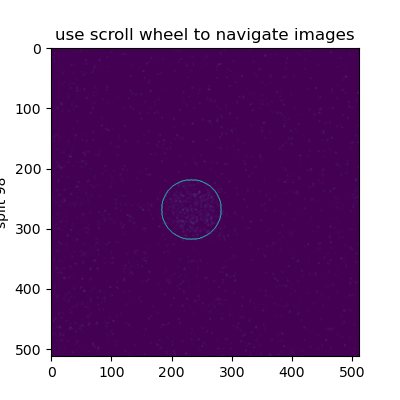

In [15]:
centerx = 233
centery = 268

zar = np.arange(0,frame_count)
img_seq_maxz = np.zeros((frame_height, frame_width, len(zar))) # numpy 3d array image sequence to track max intensity images
for zix in range(len(zar)):
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0).astype(np.uint8)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
    cv2.circle(blurred_image, (centerx, centery), 50, (255,255,255), 1)
    img_seq_maxz[:, :, zix] = blurred_image
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots(1, 1, figsize=(4,4))
tracker = tr.IndexTracker(ax, img_seq_maxz)#, args_dict)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Run through each frame and reduce the frames in the video based on the threshold

In [ ]:
# LxL blocks
threshold = 30
block_length = 5
reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

# zix = 55 # z index
# This part could be more efficient using built-in python capabilities like zip()
Rar_pxl = np.arange(2,int(reduced_height/2), dtype=np.int) # radius in pixels
central_average = np.zeros((len(Rar_pxl),frame_count), dtype=np.double)
for zix in range(frame_count):
    print("\rCalculating %d/%d..." % (zix, frame_count), end="")
    sys.stdout.flush()
    reduced_avg_img = np.zeros((int(frame_height/block_length), 
                        int(frame_width/block_length)))
    reduced_cnt_img = np.zeros((int(frame_height/block_length), 
                        int(frame_width/block_length)))
    for yix in range(len(reduced_avg_img)):
        for xix in range(len(reduced_avg_img[yix])):
            block_img = img_seq[yix*block_length:(yix+1)*block_length,
                                xix*block_length:(xix+1)*block_length,
                                zix]
            reduced_avg_img[yix,xix] = block_img.mean()
            reduced_cnt_img[yix,xix] = (block_img > threshold).sum()
            
    
    img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
        cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(img, img, mask=circle_img)

        central_average[Rix, zix] = masked_data.sum()/np.pi/radius**2

In [ ]:
fig, ax = plt.subplots(1,1)
# ax.plot(Rar_pxl, central_average[:,120])
radz = Rar_pxl[np.argmax(central_average,axis=0)]
# ax.plot(zar, radz, 'o')
ax.plot(np.max(central_average,axis=0), zar)

### Reduced images from the frames of the videos

Calculating 80/168...

<IPython.core.display.Javascript object>


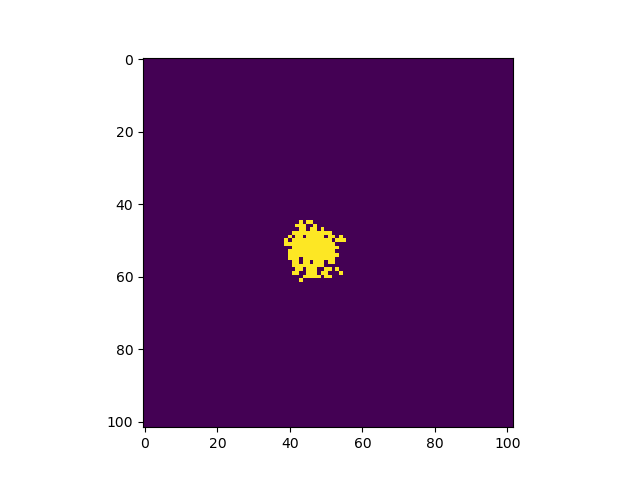

In [79]:
# Calculate circular average
# LxL blocks
pxl_threshold = 30
cnt_threshold = 3
block_length = 5

reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

zix = 80
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
reduced_cnt_img = np.zeros((int(frame_height/block_length), 
                    int(frame_width/block_length)))
img_seq = get_image_sequence(video_folder, acq_name, "t6")
for yix in range(len(reduced_avg_img)):
    for xix in range(len(reduced_avg_img[yix])):
        block_img = img_seq[yix*block_length:(yix+1)*block_length,
                            xix*block_length:(xix+1)*block_length,
                            zix]
        reduced_avg_img[yix,xix] = block_img.mean()
        reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
    
fig,ax = plt.subplots(1,1)
ax.imshow(reduced_cnt_img > cnt_threshold)

### Check the central_sum function for the given params

<IPython.core.display.Javascript object>


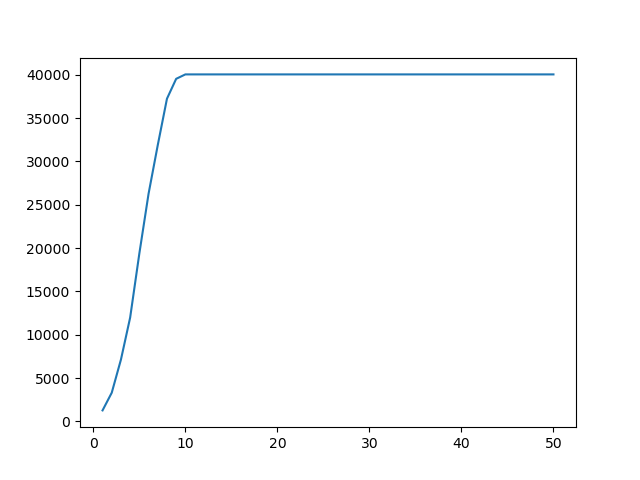

8

In [80]:
img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()

# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl, central_sum)

edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
edge_pxl

### Central average throughout all scanning direcions (z and t)

In [48]:
# Calculate circular average
# LxL blocks
zar = np.arange(0,frame_count)
tar = np.arange(0,8)
outer_radius_ar = np.zeros((len(tar), len(zar)))
for tix in range(len(tar)):
    t_str = "t%d" % (tix)
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

        reduced_avg_img = np.zeros((reduced_height, reduced_width))
        reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

        for yix in range(len(reduced_avg_img)):
            for xix in range(len(reduced_avg_img[yix])):
                block_img = img_seq[yix*block_length:(yix+1)*block_length,
                                    xix*block_length:(xix+1)*block_length,
                                    zix]
                reduced_avg_img[yix,xix] = block_img.mean()
                reduced_cnt_img[yix,xix] = (block_img > threshold).sum()

        img = ((reduced_cnt_img > 3).astype(np.uint8)*255)
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()

        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        try:
            outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
        except IndexError:
            outer_radius_ar[tix, zix] = 0

Calculating 167/168 for tix=7/8

In [87]:
csv_path = "D:/Tolga/Colony Images/EQ59_Single_Colony_TilesScan.lif/3dTimeScan_12h_init/Resources/3dTimeScan_12h_init_Movie.csv"

outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "rad_t%d (mm)" % (tix)
    df_dict[t_str] = outer_radius_mm[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(csv_path)

df_metadata = pd.DataFrame({"type": "Movie",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length},
                           index = [0])
df_metadata.to_csv(base_folder + f"Resources/{acq_name}_Movie_Metadata.csv")

In [86]:
df

,zar (mm),rad_t0 (mm),rad_t1 (mm),rad_t2 (mm),rad_t3 (mm),rad_t4 (mm),rad_t5 (mm),rad_t6 (mm),rad_t7 (mm)
0,-0.000,27.346824,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647
1,-0.006,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647
2,-0.012,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647
3,-0.018,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647
4,-0.024,54.693647,54.693647,54.693647,54.693647,54.693647,27.346824,54.693647,27.346824
...,...,...,...,...,...,...,...,...,...
163,-0.978,27.346824,54.693647,27.346824,54.693647,54.693647,54.693647,54.693647,54.693647
164,-0.984,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,27.346824,54.693647
165,-0.990,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647,54.693647
166,-0.996,54.693647,54.693647,27.346824,54.693647,54.693647,54.693647,54.693647,54.693647


(8, 168)


<IPython.core.display.Javascript object>


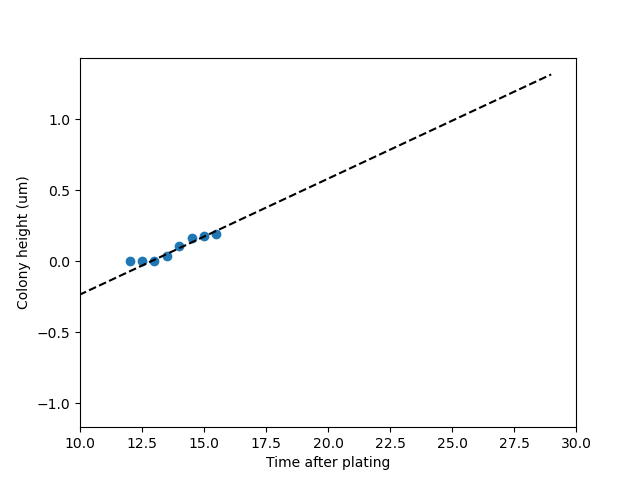

array([ 0.0816, -1.0508])

In [54]:
print(outer_radius_ar.shape)
tar = np.arange(0,8)
height = np.zeros_like(tar)
for tix in range(len(tar)):
    height[tix] = (outer_radius_ar[tix,:]>2).sum()
    
t = tar/2 + 12
h = -height*zvoxel
fig,ax = plt.subplots(1,1, dpi=100)
ax.plot(t, h, 'o')
ax.set_xlim(10,30)
# ax.set_ylim(0,4)
ax.set_xlabel(r'Time after plating')
ax.set_ylabel(r'Colony height (um)')

p = np.polyfit(t[2:],h[2:],1)
tt = np.arange(0,30)
hh = p[0]*tt + p[1]
ax.plot(tt,hh, 'k--')
p

In [88]:
df_metadata

,type,pxl_threshold,cnt_threshold,centerx,centery,block_length
0,Movie,30,3,233,268,5
